In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd 

from sklearn import svm 
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
data = np.load('data.npy')

In [3]:
trials_num = np.shape(data)[1]

beg = np.arange(0, 28)
en = np.arange(29, trials_num)

trials = np.concatenate((beg, en))
data = data[:, trials, :]
trials_num = trials_num - 1

In [4]:
data = np.mean(data, axis=1)

In [5]:
data.shape

(399, 2430)

In [6]:
np.save('classification_data', data)

In [7]:
key = pd.read_csv('key.csv')

In [8]:
area_list = key['ccf']

In [9]:
len(area_list)

399

In [10]:
area_list_unique = []
for area in area_list:
    if area not in area_list_unique:
        area_list_unique.append(area)

In [11]:
area_list_unique

["b'CA'",
 "b'VISam'",
 "b'DG'",
 "b'VISp'",
 "b'VISl'",
 "b'none'",
 "b'VISal'",
 "b'VISrl'"]

In [12]:
area_ind_list = []
for key in area_list_unique: 
    area_ind= [i for i, area in enumerate(area_list) if area==key]
    area_ind_list.append(area_ind)

In [13]:
area_ind_len = []
for i in range(8):
    area_ind_len.append(len(area_ind_list[i]))

In [14]:
area_ind_list[5]

[222]

In [15]:
data = np.delete(data, 222, axis=0)

In [16]:
data.shape

(398, 2430)

In [17]:
np.save('classification_data', data)

In [18]:
area_list = np.asarray(area_list)

In [19]:
area_list = np.delete(area_list, 222)

In [20]:
area_list.shape

(398,)

In [21]:
np.save('classification_area', area_list)

In [22]:
area_list_unique = np.asarray(area_list_unique)
area_list_unique = np.delete(area_list_unique, 5)

In [23]:
np.save('classification_area_list_unique', area_list_unique)

In [24]:
area_list_unique = area_list_unique.tolist()

In [25]:
area_ind_list = []
for area in area_list:
    area_ind_list.append(area_list_unique.index(area))

In [26]:
np.save('classification_area_ind_list', area_ind_list)

In [27]:
len(area_ind_list)

398

## Unsupervised Classification 

## k-means

In [28]:
from sklearn.cluster import KMeans

In [29]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(data)

In [30]:
prediction = kmeans.labels_

In [31]:
def plot(prediction, title):
    plt.figure(figsize=(14,6))
    for i_label in range(7):
        pred_ind = [i for i, pred in enumerate(prediction) if pred==i_label]
        area_num = np.zeros((7,))
        for i_pred in pred_ind:
            area = area_ind_list[i_pred]
            area_num[area]+=1
        
        labels = area_list_unique
        sizes = area_num

        plt.subplot(2,4,i_label+1)
        plt.pie(sizes, labels=labels, autopct='%1.1f%%')
        plt.axis('equal')
        plt.title('Cluster '+str(i_label+1))
        plt.savefig(title+'.png', dpi=200)

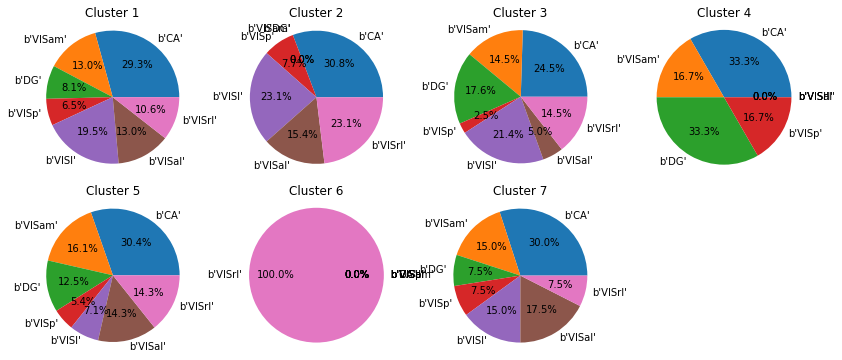

In [32]:
plot(prediction, 'k-means')

### GMM

In [33]:
from sklearn.mixture import GaussianMixture

In [34]:
gmm = GaussianMixture(n_components=7)

In [35]:
data.shape

(398, 2430)

In [36]:
gmm.fit(data)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [37]:
labels = gmm.predict(data)

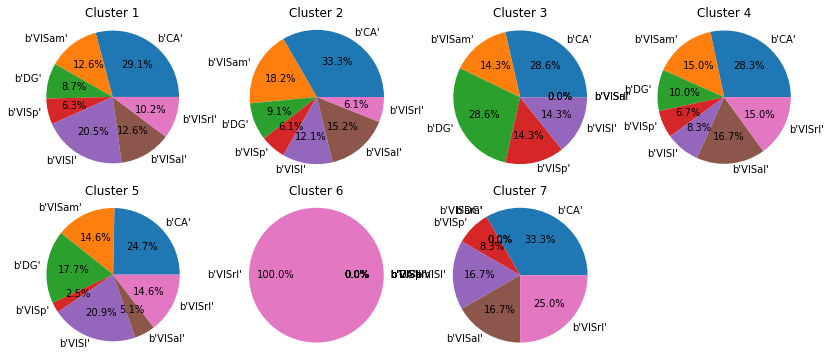

In [38]:
plot(labels, 'GMM')

## Supervised Classification

In [39]:
data.shape

(398, 2430)

In [40]:
area_ind_list = np.asarray(area_ind_list)
area_ind_list.shape
label = area_ind_list

In [41]:
def get_data(data, label, num_train=250, num_test=100):
    train_ind = np.random.choice(data.shape[0], num_train, replace=False)
    left_ind = [i for i in np.arange(data.shape[0]) if i not in train_ind]
    test_i= np.random.choice(data.shape[0]-num_train, num_test, replace=False)
    test_ind = [left_ind[i] for i in test_i]
    
    train_data = [data[i,:] for i in train_ind]
    train_label = [label[i] for i in train_ind]
    test_data = [data[i,:] for i in test_ind]
    test_label = [label[i] for i in test_ind]

    train_data = np.asarray(train_data)
    train_label = np.asarray(train_label)
    test_data = np.asarray(test_data)
    test_label = np.asarray(test_label)
    return train_data, train_label, test_data, test_label

In [42]:
def test_KNeigh(data, label, num_trial=100):
    acc_list = np.zeros((num_trial,))
    for i_trial in range(num_trial):
        train_data, train_label, test_data, test_label = get_data(data, label)
        neigh = KNeighborsClassifier(n_neighbors=3)
        neigh.fit(train_data, train_label)
        pred = neigh.predict(test_data)
        acc = 100*np.sum((pred-test_label)==0)/50
        acc_list[i_trial] = acc
    return acc_list

In [43]:
def test_NaiveB(data, label, num_trial=100):
    acc_list = np.zeros((num_trial,))
    for i_trial in range(num_trial):
        train_data, train_label, test_data, test_label = get_data(data, label)
        gnb = GaussianNB()
        pred = gnb.fit(train_data, train_label).predict(test_data)
        acc = 100*np.sum((pred-test_label)==0)/50
        acc_list[i_trial] = acc
    return acc_list

In [44]:
from sklearn.svm import SVC
def test_SVC(data, label, num_trial=100):
    acc_list = np.zeros((num_trial,))
    for i_trial in range(num_trial):
        train_data, train_label, test_data, test_label = get_data(data, label)
        clf = SVC(gamma='auto')
        clf.fit(train_data, train_label)
        score_SVM = clf.score(test_data, test_label)
        acc_list[i_trial] = 100*score_SVM
    return acc_list

In [45]:
from sklearn.tree import DecisionTreeClassifier
def test_Tree(data, label, num_trial=100):
    acc_list = np.zeros((num_trial,))
    for i_trial in range(num_trial):
        train_data, train_label, test_data, test_label = get_data(data, label)
        clf = DecisionTreeClassifier()
        clf.fit(train_data, train_label)
        score_RF = clf.score(test_data, test_label)
        acc_list[i_trial] = 100*score_RF
    return acc_list

In [46]:
acc_list = [[] for i in range(4)]
acc_list[0] = test_KNeigh(data, label)
acc_list[1] = test_NaiveB(data, label)
acc_list[2] = test_SVC(data, label)
acc_list[3] = test_Tree(data, label)

In [47]:
acc_mean = np.zeros((4,))
acc_std = np.zeros((4,))
for i in range(4):
    acc_mean[i] = np.mean(acc_list[i])
    acc_std[i] = np.std(acc_list[i])

([<matplotlib.axis.XTick at 0x1a48bf8b630>,
 <a list of 4 Text xticklabel objects>)

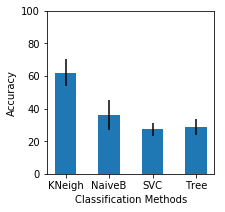

In [48]:
plt.figure(figsize=(3,3))
plt.bar(np.arange(4), acc_mean, 0.5, yerr=acc_std)
plt.xlabel('Classification Methods')
plt.ylabel('Accuracy')
plt.ylim([0,100])
plt.xticks(np.arange(4), ('KNeigh', 'NaiveB', 'SVC', 'Tree'))

In [49]:
acc_mean

array([61.98, 36.24, 27.33, 28.54])

In [50]:
np.mean(acc_mean)

38.5225